# Overview

Covering:
- Implementation of 1D acoustic wave equation from scratch
- Understanding the input parameters for the simulation 
- Understanding CFL condition
- Implemention of variable source/receiver locations to generate seismogram

# Introduction

The acoustic wave equation in 1D with constant density is defined as

$$
\partial^2_t p(x,t) \ = \ c(x)^2 \partial_x^2 p(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$ contains two second derivatives. For numerical analysis, the derivatives can be approximated with a centered difference formula given as

$$
\partial^2_t p(x,t) \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2} 
$$

$$
\partial^2_x p(x,t) \ \approx \ \frac{p(x+dx,t) - 2 p(x,t) + p(x-dx,t)}{dx^2} 
$$

Injecting these approximations into the wave equation allows us to formulate the pressure $p(x)$ for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an explicit scheme allowing the *extrapolation* of the space-dependent field into the future only looking at the nearest neighbourhood.

Replacing the 2nd order time derivative with the approximation we get

$$
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{dt^2} \ = \ c^2 ( \partial_x^2 p) \ + s_{i}^n
$$

solving for $p_{i}^{n+1}$.

The extrapolation scheme is

$$
p_{i}^{n+1} \ = \ c_i^2 \mathrm{d}t^2 \left[ \partial_x^2 p \right]
+ 2p_{i}^n - p_{i}^{n-1} + \mathrm{d}t^2 s_{i}^n
$$

where the space derivative is determined by 

$$
\partial_x^2 p \ = \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Space Discretization
x_min = 0
x_max = 1000
nx = 1001
dx = (x_max-x_min)/(nx-1)
x = np.linspace(x_min, x_max, nx)
c0 = 334 # Homogeneous medium Wave Speed

# Time Discretization
t_min = 0
t_max = 100
nt = 200001
dt = (t_max-t_min)/(nt-1)
t = np.linspace(t_min, t_max, nt)

# CFL Stability Criterion
eps = c0 * dt / dx

print("Eps: ", eps)

Eps:  0.167


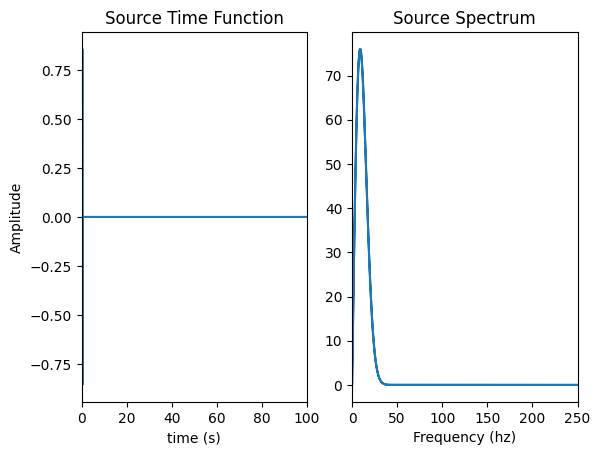

In [6]:
# Defining Source Function
f0 = 10 # Dominant Frequency
t0 = 4 / f0 # Source Time Shift
isrc = int(nx/2) # Source Location

src = -8. * (t - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (t - t0) ** 2))

# Plotting Source Function
plt.subplot(1, 2, 1)
plt.plot(t, src)
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
plt.xlim(t_min, t_max)
plt.title("Source Time Function")

plt.subplot(1, 2, 2)
spec = np.fft.fft(src)
freq = np.fft.fftfreq(spec.size, d=dt)
plt.plot(np.abs(freq), np.abs(spec))
plt.xlabel("Frequency (hz)")
plt.xlim(0, 250)
plt.title("Source Spectrum")

plt.show()

In [7]:
# Finite Difference Simulation

# Initialize pressure fields
p = np.zeros(nx) # P(x, t)
p_old = np.zeros(nx) # p(x, t-dt)

p_sol = [] # Will save p at all time steps to simulate later

# 2nd Space Derivative Initialization
d2px = np.zeros(nx)

# Time Stepping
for it in range(nt):
    # 2nd derivative in space (Centered Differnce applied on whole grid)
    d2px[1:-1] = (p[2:] - 2*p[1:-1] + p[:-2])/(dx**2)

    # Next time step
    p_new = ((c0*dt)**2)*d2px + 2*p - p_old 
    p_new[isrc] += src[it] * (dt**2) #/ dx

    # Store result
    p_sol.append(p_new)

    # Remap arrays
    p_old = p
    p = p_new

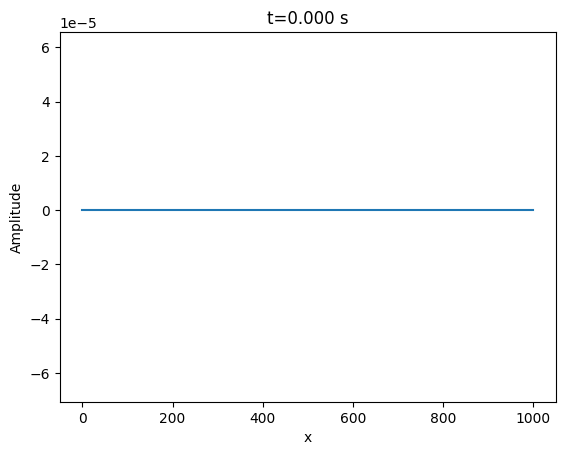

In [8]:
from matplotlib.animation import FuncAnimation

p_min = np.min(p_sol)
p_max = np.max(p_sol)
# Define the update function for the animation
def animate(i):
    plt.cla()  # Clear the previous plot
    plt.plot(p_sol[i*100])  # Plot the updated data
    plt.xlabel('x')
    plt.ylabel('Amplitude')
    plt.ylim(p_min, p_max)
    plt.title('t={:.3f} s'.format(t[i*100]))

# Create the animation
fig, ax = plt.subplots()
ani = FuncAnimation(fig, animate, frames=len(p_sol[::100]), blit=False)

# Save the animation (optional)
ani.save('dynamic_plot_.gif', writer='pillow')